In [24]:
import os
import tensorflow as tf
assert tf.__version__.startswith('2')

from mediapipe_model_maker import gesture_recognizer

import matplotlib.pyplot as plt

from mediapipe.tasks.python import vision
import mediapipe as mp
import cv2
import time

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


2023-06-03 14:19:53.667832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 14:19:54.816719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/guillaume/anaconda3/envs/semproj/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:
2023-06-03 14:19:54.816833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/guillaume/ana

In [25]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Train the classifier

In [107]:
# !wget https://storage.googleapis.com/mediapipe-tasks/gesture_recognizer/rps_data_sample.zip
# !unzip rps_data_sample.zip
dataset_path = "hands"


In [108]:
print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)


hands
['stay', 'come', 'none', 'sit', 'hands_down', 'down']


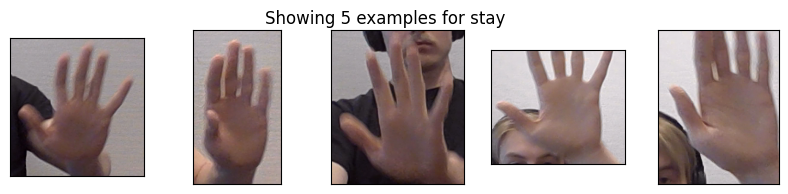

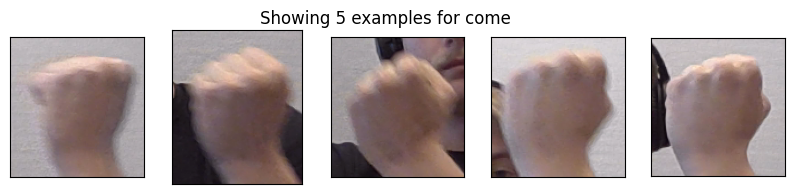

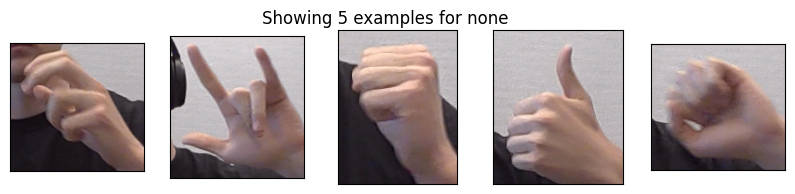

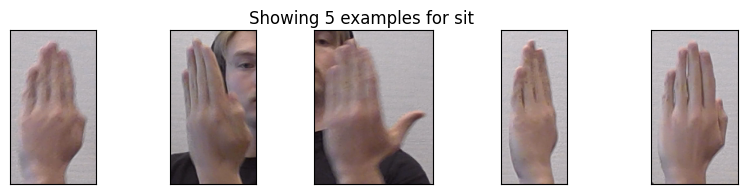

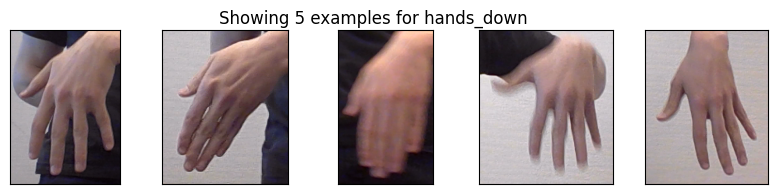

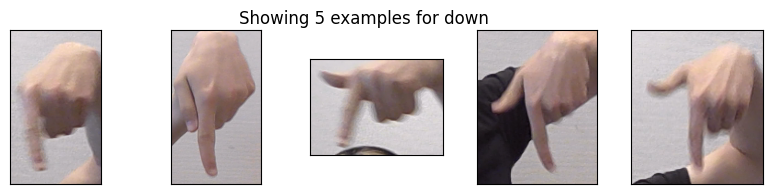

In [109]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()


In [110]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)


Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_317.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_318.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_310.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_128.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_312.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_311.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_313.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_308.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_125.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_305.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_289.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_172.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_304.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_70.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_272.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_231.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_75.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_78.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_236.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_9.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_271.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_222.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_278.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_285.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_3.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_229.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_316.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_136.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_157.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_42.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_168.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_41.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_48.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_14.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_93.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_221.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_37.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_281.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_127.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_90.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_195.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_265.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_138.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_165.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_148.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_130.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_215.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_158.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_297.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_258.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_241.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_38.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_287.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_1.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_198.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_53.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_189.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_254.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_264.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_245.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_54.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_55.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_280.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_219.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_83.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_203.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_121.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_182.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_176.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_211.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_263.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_122.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_193.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_253.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_62.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_47.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_56.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_299.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_8.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_201.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_314.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_124.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_60.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_196.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_179.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_303.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_68.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_301.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_228.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_184.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_309.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_160.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_146.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_275.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_190.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_31.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_188.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_109.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_99.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_28.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_273.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_34.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_163.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_7.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_86.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_147.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_248.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_276.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_234.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_183.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_85.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_244.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_177.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_6.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_65.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_119.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_250.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_171.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_103.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_73.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_123.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_283.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_266.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_237.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_284.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_191.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_71.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_116.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_13.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_210.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_169.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_256.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_2.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_199.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_61.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_279.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_108.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_84.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_200.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_243.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_132.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_135.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_76.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_207.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_88.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_17.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_79.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_111.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_159.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_69.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_72.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_114.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_96.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_249.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_150.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_91.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_141.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_252.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_33.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_268.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_187.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_162.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_140.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_137.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_270.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_226.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_218.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_89.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_104.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_39.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_102.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_315.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_232.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_19.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_74.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_294.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_77.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_238.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_57.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_10.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_152.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_290.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_259.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_251.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_115.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_118.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_106.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_149.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_58.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_21.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_23.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_246.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_192.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_95.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_166.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_167.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_306.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_145.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_296.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_12.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_300.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_155.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_257.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_220.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_260.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_5.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_307.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_197.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_22.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_291.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_25.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_94.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_214.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_235.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_110.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_134.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_32.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_173.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_293.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_202.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_29.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_302.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_144.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_261.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_49.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_142.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_98.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_20.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_143.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_227.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_120.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_282.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_153.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_286.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_269.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_230.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_175.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_213.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_59.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_26.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_81.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_151.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_240.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_181.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_43.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_36.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_4.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_126.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_217.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_131.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_267.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_186.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_247.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_40.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_262.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_100.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_298.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_180.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_105.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_209.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_67.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_216.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_101.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_194.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_87.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_24.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_11.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_206.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_277.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_255.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_164.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_139.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_288.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_46.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_51.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_208.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_97.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_295.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_27.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_113.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_185.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_239.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_16.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_223.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_82.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_18.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_64.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_117.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_30.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/none/1_274.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_129.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_50.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_112.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_80.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_92.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_154.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_52.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_174.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_205.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_15.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_44.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_45.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_212.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_225.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_63.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_156.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_133.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/sit/1_233.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_170.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_0.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_107.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_161.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_66.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_242.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_224.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/hands_down/1_35.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/stay/1_178.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/come/1_204.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_292.png


INFO:tensorflow:Loading image /home/guillaume/Desktop/MA4/Semester-project-MA4/action recognition pipeline/hand poses/hands/down/1_292.png


Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder
INFO:tensorflow:Load valid hands with size: 1482, num_label: 6, labels: none,come,down,hands_down,sit,stay.


INFO:tensorflow:Load valid hands with size: 1482, num_label: 6, labels: none,come,down,hands_down,sit,stay.


In [111]:
hparams = gesture_recognizer.HParams(export_dir="exported_model_3")
hparams.epochs = 15
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer)  [(None, 128)]            0         
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_o  (None, 6)                774       
 ut (Dense)                                                      
                                                                 
Total params: 1,286
Trainable params: 1,030
Non-trainable p

INFO:tensorflow:Training the models...


Epoch 1/15
592/592 [==============================] - 1s 1ms/step - loss: 0.9268 - categorical_accuracy: 0.4434 - val_loss: 0.2252 - val_categorical_accuracy: 0.7973 - lr: 0.0010
Epoch 2/15
592/592 [==============================] - 1s 1ms/step - loss: 0.6379 - categorical_accuracy: 0.6275 - val_loss: 0.1468 - val_categorical_accuracy: 0.8986 - lr: 9.9000e-04
Epoch 3/15
592/592 [==============================] - 1s 1ms/step - loss: 0.5703 - categorical_accuracy: 0.6715 - val_loss: 0.1268 - val_categorical_accuracy: 0.9122 - lr: 9.8010e-04
Epoch 4/15
592/592 [==============================] - 1s 1ms/step - loss: 0.5295 - categorical_accuracy: 0.6951 - val_loss: 0.1157 - val_categorical_accuracy: 0.9122 - lr: 9.7030e-04
Epoch 5/15
592/592 [==============================] - 1s 1ms/step - loss: 0.5136 - categorical_accuracy: 0.7086 - val_loss: 0.0992 - val_categorical_accuracy: 0.9122 - lr: 9.6060e-04
Epoch 6/15
592/592 [==============================] - 1s 1ms/step - loss: 0.5034 - catego

In [112]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")


149/149 [==============================] - 1s 550us/step - loss: 0.1120 - categorical_accuracy: 0.8993
Test loss:0.1120249480009079, Test accuracy:0.899328887462616


In [113]:
model.export_model()
!ls exported_model


Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/canned_gesture_classifier.tflite
INFO:tensorflow:Assets written to: /tmp/tmp0b245i_k/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/tmp0b245i_k/saved_model/assets
2023-06-01 17:33:07.085688: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-06-01 17:33:07.085712: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-06-01 17:33:07.085815: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0b245i_k/saved_model
2023-06-01 17:33:07.086742: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-06-01 17:33:07.086764: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0b245i_k/saved_model
2023-06-01 17:33:07.089182: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-06-01 17:33:07.101606: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0b245i_k/saved_model
2023-06-01 17:33:07.105940: I ten

best_model_weights.data-00000-of-00001	epoch_models		 metadata.json
best_model_weights.index		gesture_recognizer.task
checkpoint				logs


## visual tests using webcam

In [26]:
recognizer = vision.GestureRecognizer.create_from_model_path("exported_model_3/gesture_recognizer.task")

W20230603 14:19:58.728771  7564 gesture_recognizer_graph.cc:128] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Hands only

In [8]:
new_frame_time = 0
prev_frame_time = 0

# Open the webcam
cap = cv2.VideoCapture(0)  # 0 represents the default webcam, change it if necessary

# Check if the webcam is successfully opened
if not cap.isOpened():
    print("Unable to open the webcam.")

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
    

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()
    
    # Check if the frame is successfully read
    if not ret:
        print("Failed to read the frame.")
        break

    frame = cv2.flip(frame,1)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
    result = recognizer.recognize_async(mp_image) #hands detection and classification

    try:
        prediction = result.gestures[0][0].category_name
        confidence = result.gestures[0][0].score  
        hand_landmarks = result.hand_world_landmarks
        
        if prediction == None:
            prediction = "None"
    
    except:
        prediction = "no hands"
        confidence = ""

    annotated_image = draw_landmarks_on_image(frame, result)

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # Write the prediction text on the frame
    cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame in a window named 'Webcam Feed'
    cv2.imshow('Webcam Feed', annotated_image)
    
    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

Unable to open the webcam.
Failed to read the frame.


[ WARN:0@471.300] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@471.415] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


### Hands and body keypoints

In [126]:
new_frame_time = 0
prev_frame_time = 0

# Open the webcam
cap = cv2.VideoCapture(0)  # 0 represents the default webcam, change it if necessary

# Check if the webcam is successfully opened
if not cap.isOpened():
    print("Unable to open the webcam.")

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
    
with mp_pose.Pose(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    while True:
        # Read a frame from the webcam
        ret, frame = cap.read()
        # Check if the frame is successfully read
        if not ret:
            print("Failed to read the frame.")
            break

        frame = cv2.flip(frame,1)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
        result = recognizer.recognize(mp_image) #hands detection and classification
        pose_results = pose.process(frame) # find body keypoints

        try:
            prediction = result.gestures[0][0].category_name
            confidence = result.gestures[0][0].score  
            hand_landmarks = result.hand_world_landmarks
            
            if prediction == None:
                prediction = "None"
        
        except:
            prediction = "no hands"
            confidence = ""

        annotated_image = draw_landmarks_on_image(frame, result)

        mp_drawing.draw_landmarks(
        annotated_image,
        pose_results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # Write the prediction text on the frame
        cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display the frame in a window named 'Webcam Feed'
        cv2.imshow('Webcam Feed', annotated_image)
        
        # Exit the loop if the 'q' key is pressed
        if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
            break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

## Using realsense

### start the pipeline

In [130]:
import pyrealsense2 as rs

pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)

device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))
found_rgb = False

for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)



if device_product_line == 'L500':
    config.enable_stream(rs.stream.color, 960, 540, rs.format.bgr8, 30)
else:
    config.enable_stream(rs.stream.color, 1280, 800, rs.format.bgr8, 30)



### Using livestream model


In [5]:
pipeline.stop()
cv2.destroyAllWindows()

In [3]:
import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
GestureRecognizerResult = mp.tasks.vision.GestureRecognizerResult
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the live stream mode:
def print_result(result: GestureRecognizerResult, output_image: mp.Image, timestamp_ms: int, global_result):
    print('gesture recognition result: {}'.format(result))
    glob_result = result

# crashes the kernel if used ....
# def display_results(result: GestureRecognizer, output_image: mp.Image, timestamp_ms: int, global_result):
    
#     prediction = glob_result.gestures[0][0].category_name
#     confidence = glob_result.gestures[0][0].score  
#     annotated_image = draw_landmarks_on_image(output_image.numpy_view(), result)
#     cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#     cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
#     # Display the frame in a window named 'Webcam Feed'
#     cv2.imshow('Webcam Feed', annotated_image)


options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='exported_model_3/gesture_recognizer.task'),
    running_mode=VisionRunningMode.LIVE_STREAM,
    result_callback=print_result)

global glob_result
glob_result = None

with GestureRecognizer.create_from_options(options) as recognizer:
    pipeline.start(config)

    new_frame_time = 0
    prev_frame_time = 0

    cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
        
    while True:

        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()

        timestamp = color_frame.get_timestamp()
        print(timestamp)
        
        if not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())

        frame = cv2.flip(color_image,1)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
        recognizer.recognize_async(mp_image, int(timestamp)) #hands detection and classification

        try:
            prediction = glob_result.gestures[0][0].category_name
            confidence = glob_result.gestures[0][0].score  

            annotated_image = draw_landmarks_on_image(frame, result)
            
            if prediction == None:
                prediction = "None"
        
        except:
            prediction = "no hands"
            confidence = ""
            annotated_image = frame

    
        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time

        # Write the prediction text on the frame
        cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Display the frame in a window named 'Webcam Feed'
        cv2.imshow('Webcam Feed', annotated_image)
        
        # Exit the loop if the 'q' key is pressed
        if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
            break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()
    

W20230602 19:05:14.966527 16002 gesture_recognizer_graph.cc:128] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


: 

: 

### Hands only

In [5]:
import time

In [6]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)
    
while True:

    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    
    if not color_frame:
        continue

    color_image = np.asanyarray(color_frame.get_data())

    frame = cv2.flip(color_image,1)

    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
    result = recognizer.recognize_async(mp_image, time.time()) #hands detection and classification

    try:
        prediction = result.gestures[0][0].category_name
        confidence = result.gestures[0][0].score  
        hand_landmarks = result.hand_world_landmarks
        
        if prediction == None:
            prediction = "None"
    
    except:
        prediction = "no hands"
        confidence = ""

    annotated_image = draw_landmarks_on_image(frame, result)

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # Write the prediction text on the frame
    cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame in a window named 'Webcam Feed'
    cv2.imshow('Webcam Feed', annotated_image)
    
    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
        break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()

TypeError: at(): incompatible function arguments. The following argument types are supported:
    1. (self: mediapipe.python._framework_bindings.packet.Packet, arg0: int) -> mediapipe.python._framework_bindings.packet.Packet
    2. (self: mediapipe.python._framework_bindings.packet.Packet, arg0: mediapipe.python._framework_bindings.timestamp.Timestamp) -> mediapipe.python._framework_bindings.packet.Packet

Invoked with: <mediapipe.Packet with timestamp: UNSET and C++ type: ::mediapipe::Image>, 1685720736726.827

### Hands and body

In [41]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)

import mediapipe as mp

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the image mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='exported_model_3/gesture_recognizer.task'),
    running_mode=VisionRunningMode.IMAGE,
    num_hands = 1,
    min_hand_detection_confidence=0.1,
    min_hand_presence_confidence=0.1)
with GestureRecognizer.create_from_options(options) as recognizer:
    with mp_pose.Pose(
        model_complexity=0,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:    
        while True:

            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            
            if not color_frame:
                continue

            color_image = np.asanyarray(color_frame.get_data())

            frame = cv2.flip(color_image,1)

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame)
            result = recognizer.recognize(mp_image) #hands detection and classification
            pose_results = pose.process(frame) # find body keypoints

            # print(f"hand results {result}")


            try:
                prediction = result.gestures[0][0].category_name
                confidence = result.gestures[0][0].score  
                hand_landmarks = result.hand_world_landmarks
                
                if prediction == None:
                    prediction = "None"
            
            except:
                prediction = "no hands"
                confidence = ""

            annotated_image = draw_landmarks_on_image(frame, result)

            mp_drawing.draw_landmarks(
            annotated_image,
            pose_results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

            new_frame_time = time.time()
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time

            # Write the prediction text on the frame
            print(prediction)
            cv2.putText(annotated_image, f"{prediction} {confidence}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display the frame in a window named 'Webcam Feed'
            cv2.imshow('Webcam Feed', annotated_image)
            
            # Exit the loop if the 'q' key is pressed
            if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
                break

    # Release the webcam and close the window
    pipeline.stop()
    cv2.destroyAllWindows()

W20230603 13:52:50.133942 46036 gesture_recognizer_graph.cc:128] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.


no hands
no hands
no hands
no hands
none
none
none
none
none
none
none

none
none

none
none
no hands
no hands

no hands

no hands
none
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
none
no hands

no hands

no hands
no hands
no hands


none
no hands


no hands
no hands
no hands
no hands
no hands
no hands




no hands
none
none
none

no hands

no hands
no hands
none
down
down
down
down
down
down
down
none
down
down
none
none
down
none
none
down
none
none
none
none
none
none
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
down
none
down
down
none
none
down
down
no hands
no hands
down
down
down
down
down
down
down
down


down
down
down

down

sit

none






















stay
down

down
none
down
down
none
none
down





no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no hands
no 

### Hands and body with hand recrop

In [124]:
def get_hand_coordinates(pose_landmarks):
    left_hand_coords = {"max_x": -1000, "max_y": -1000, "min_x": 1000, "min_y": 1000}
    right_hand_coords = {"max_x": -1000, "max_y": -1000, "min_x": 1000, "min_y": 1000}

    left_hand_index = [17, 19, 21] # wrist pinky index thumb
    right_hand_index = [18, 20, 22]

    margin = 0

    # Extract the coordinates of the left and right hands
    for idx, landmark in enumerate(pose_landmarks.landmark):
        if idx in left_hand_index:
              # Left hand
            if landmark.x > left_hand_coords["max_x"]:
                left_hand_coords["max_x"] = landmark.x
            if landmark.y > left_hand_coords["max_y"]:
                left_hand_coords["max_y"] = landmark.y
            if landmark.x < left_hand_coords["min_x"]:
                left_hand_coords["min_x"] = landmark.x
            if landmark.y < left_hand_coords["min_y"]:
                left_hand_coords["min_y"] = landmark.y

        elif idx in right_hand_index:  # Right hand

            if landmark.x > right_hand_coords["max_x"]:
                right_hand_coords["max_x"] = landmark.x
            if landmark.y > right_hand_coords["max_y"]:
                right_hand_coords["max_y"] = landmark.y
            if landmark.x < right_hand_coords["min_x"]:
                right_hand_coords["min_x"] = landmark.x
            if landmark.y < right_hand_coords["min_y"]:
                right_hand_coords["min_y"] = landmark.y


    if any(item < 0 or item > 1 for item in left_hand_coords.values()): # coordinates are out of the frame
        left_hand_coords = None
    if any(item <0 or item > 1 for item in right_hand_coords.values()):
        right_hand_coords = None

    return right_hand_coords, left_hand_coords # we have to switch them here due to the cv2.flip

def crop_hand(frame, hand_coords):
    # image_height, image_width = frame.height, frame.width
    
    image_height, image_width, _ = frame.shape

    margin = 80

    x_min = max(0, int(hand_coords["min_x"] * image_width) - margin)
    y_min = max(0, int(hand_coords["min_y"] * image_height) - margin)
    x_max = min(image_width - 1, int(hand_coords["max_x"] * image_width) + margin)
    y_max = min(image_height - 1, int(hand_coords["max_y"] * image_height) + margin)

    # Crop the image around the hand region
    hand_image = frame[y_min:y_max, x_min:x_max]

    return hand_image

In [125]:
def classify_hand(mp_image):

        # mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = hand_image)
        # mp_image = hand_image
        result = recognizer.recognize(mp_image) 
    
        try:
            prediction = result.gestures[0][0].category_name
            confidence = result.gestures[0][0].score          
        except:
            prediction = "no hands hee"
            confidence = ""

        return prediction, confidence

In [133]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)

BaseOptions = mp.tasks.BaseOptions
GestureRecognizer = mp.tasks.vision.GestureRecognizer
GestureRecognizerOptions = mp.tasks.vision.GestureRecognizerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a gesture recognizer instance with the image mode:
options = GestureRecognizerOptions(
    base_options=BaseOptions(model_asset_path='exported_model_3/gesture_recognizer.task'),
    running_mode=VisionRunningMode.IMAGE,
    num_hands = 1,
    min_hand_detection_confidence=0.2,
    min_hand_presence_confidence=0.2)
with GestureRecognizer.create_from_options(options) as recognizer:


    with mp_pose.Pose(
        model_complexity=1,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:    
        while True:

            frames = pipeline.wait_for_frames()
            color_frame = frames.get_color_frame()
            
            if not color_frame:
                continue

            color_image = np.asarray(color_frame.get_data())
            frame = cv2.flip(color_image,1)

            #hands detection and classification
            pose_results = pose.process(frame) # find body keypoints

            right_pred = "no hands"
            right_conf = ""

            if pose_results.pose_landmarks:
                # Get the coordinates of the left and right hands
                _, right_hand_coords = get_hand_coordinates(pose_results.pose_landmarks)
                
                if right_hand_coords is not None:
                    right_hand_image = (crop_hand(frame, right_hand_coords))
                    # right_hand_image = cv2.flip(right_hand_image,1)
                    # right_hand_image = cv2.flip(right_hand_image,1)
                    right_hand_image = cv2.cvtColor(right_hand_image, cv2.COLOR_BGR2RGB)
                    right_hand_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = right_hand_image)
                    right_pred, right_conf = classify_hand(right_hand_image)
                    

                    # Draw the bounding box and prediction on the frame
                    margin_x = 80
                    margin_y = int(margin_x * 1.25)
                    image_height, image_width, _ = frame.shape
                    x_min = max(0, int(right_hand_coords["min_x"] * image_width) - margin_x)
                    y_min = max(0, int(right_hand_coords["min_y"] * image_height) - margin_y)
                    x_max = min(image_width - 1, int(right_hand_coords["max_x"] * image_width) + margin_x)
                    y_max = min(image_height - 1, int(right_hand_coords["max_y"] * image_height) + margin_y)
                    start_box = (x_min, y_min)
                    end_box = (x_max, y_max)
                    frame = cv2.rectangle(frame, start_box, end_box, (255,0,0), 2)
                    cv2.putText(frame, right_pred, start_box, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)



            # annotated_image = draw_landmarks_on_image(frame, result)
            annotated_image = frame

            mp_drawing.draw_landmarks(
            annotated_image,
            pose_results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

            new_frame_time = time.time()
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time

            # Write the prediction text on the frame
            # cv2.putText(annotated_image, f"Left hand: {left_pred} ({left_conf})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # cv2.putText(annotated_image, f"Right hand: {right_pred} ({right_conf})", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Display the frame in a window named 'Webcam Feed'
            cv2.imshow('Webcam Feed', annotated_image)
            
            # Exit the loop if the 'q' key is pressed
            if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
                break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()

W20230604 10:03:59.429419  7564 gesture_recognizer_graph.cc:128] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.


In [127]:
color_frame

<pyrealsense2.frame BGR8 #923 @1685813556346.628174>

In [132]:
pipeline.stop()
cv2.destroyAllWindows()

### Openpifpaf and hand

In [16]:
import openpifpaf
import torch
import PIL
import numpy as np
import cv2
import time
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16') #could use mobilenetv3small for betterperformances

In [17]:
RED = (0, 0, 255)
GREEN = (0, 255, 0)
BLUE = (255, 0, 0)
YELLOW = (0, 255, 255)

pos_dict = {
        "nose": 0,
        "left_eye": 1,
        "right_eye": 2,
        "left_ear": 3,
        "right_ear": 4,
        "left_shoulder": 5,
        "right_shoulder": 6,
        "left_elbow": 7,
        "right_elbow": 8,
        "left_wrist": 9,
        "right_wrist": 10,
        "left_hip": 11,
        "right_hip": 12,
        "left_knee": 13,
        "right_knee": 14,
        "left_ankle": 15,
        "right_ankle": 16}

link_dict = {
        "nose": [("nose", "left_eye"),("nose", "right_eye")],
        "left_eye": [("left_eye", "left_ear")],
        "right_eye": [("right_eye", "right_ear")],
        "left_shoulder": [("left_shoulder", "left_elbow"),("left_shoulder", "left_hip"),("left_shoulder", "right_shoulder")],
        "right_shoulder": [("right_shoulder", "right_elbow"),("right_shoulder", "right_hip")],
        "left_elbow": [("left_elbow", "left_wrist")],
        "right_elbow": [("right_elbow", "right_wrist")],
        "left_hip": [("left_hip", "left_knee"),("left_hip", "right_hip")],
        "right_hip": [("right_hip", "right_knee")],
        "left_knee": [("left_knee", "left_ankle")],
        "right_knee": [("right_knee", "right_ankle")]}




In [5]:
def display_whole_skeleton(keypoints, frame, pos_dict = pos_dict, link_dict = link_dict):
    for key in pos_dict:
        try:
            keypoint = keypoints[pos_dict[key],0:2]
            cv2.circle(frame, tuple(map(int, tuple(keypoint))), 5, RED, -1)
            try:
                links = link_dict[key]
                if len(links) > 1:
                    for link in links:
                            keypoint1 = keypoints[pos_dict[link[0]],0:2]
                            keypoint2 = keypoints[pos_dict[link[1]],0:2]
                            # if keypoint1 == [0.0,0.0] or keypoint2 == [0.0,0.0]:
                            #     continue
                            cv2.line(frame, tuple(map(int, tuple(keypoint1))), tuple(map(int, tuple(keypoint2))), RED, 2)
                else:
                    keypoint1 = keypoints[pos_dict[links[0][0]],0:2]
                    keypoint2 = keypoints[pos_dict[links[0][1]],0:2]
                    # if keypoint1 == [0.0,0.0]or keypoint2 == [0.0,0.0]:
                    #     continue
                    cv2.line(frame, tuple(map(int, tuple(keypoint1))), tuple(map(int, tuple(keypoint2))), RED, 2)
            except:
                continue
        except:
            continue

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [22]:
pipeline.start(config)

new_frame_time = 0
prev_frame_time = 0

cv2.namedWindow('Webcam Feed', cv2.WINDOW_NORMAL)


while True:

    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    
    if not color_frame:
        continue

    color_image = np.asarray(color_frame.get_data())
    pil_img = PIL.Image.fromarray(color_image)
    predictions, _, _ = predictor.pil_image(pil_img)
    # mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data = frame

    # display_whole_skeleton(predictions[0].data, color_image)

    annotated_image = color_image

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time

    # Write the prediction text on the frame
    # cv2.putText(annotated_image, f"Left hand: {left_pred} ({left_conf})", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    # cv2.putText(annotated_image, f"Right hand: {right_pred} ({right_conf})", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"FPS: {fps}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Display the frame in a window named 'Webcam Feed'
    cv2.imshow('Webcam Feed', annotated_image)
    
    # Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) == 27:  # 27 is the ASCII code for the Escape key
        break

# Release the webcam and close the window
pipeline.stop()
cv2.destroyAllWindows()

In [20]:
pipeline.stop()
cv2.destroyAllWindows()